In [11]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, plotContourTruncatedNormal
import seaborn as sns
import tensorflow as tf
from efn_util import drawPoissonCounts, setup_IO
from plot_util import exptrend, sattrend, load_V1_events
import scipy.io as sio
from families import family_from_str

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'lgc';
D = 2;

basedir = '/Users/sbittner/Documents/efn/';
dir_str = exp_fam;

fam_class = family_from_str(exp_fam);
family = fam_class(D);

T_s = .02;
K = 100;
M = 100;
TIF_flow_type = 'PlanarFlowLayer'; 
nlayers = 10;
flow_dict = {'latent_dynamics':None, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
param_net_hps = {'L':4};
stochastic_eta = True;
give_hint = False;
rs = 0;

In [12]:
def easy_inds():
    num_monkeys = 3;
    num_neurons = [83, 59, 105]
    num_oris = 12;
    N = int(sum(num_neurons*num_oris));
    monkeys = np.zeros((N,));
    neurons = np.zeros((N,));
    oris = np.zeros((N,));

    ind = 0;
    for i in range(num_monkeys):
        monkey = i+1;
        nneurons = num_neurons[i];
        for j in range(nneurons):
            neuron = j+1;
            for k in range(num_oris):
                ori = k+1;
                monkeys[ind] = monkey;
                neurons[ind] = neuron;
                oris[ind] = ori;
                ind += 1;
    return monkeys, neurons, oris;


def load_counts_spikes(monkey, neuron, ori):
    # get counts
    respdir = '/Users/sbittner/Documents/efn/data/responses/';
    fname = respdir + 'spike_counts_monkey%d_neuron%d_ori%d.mat' % (monkey, neuron, ori);
    M = sio.loadmat(fname);
    counts = M['x'];
    
     # get spikes
    SNR_thresh = 1.5;
    FR_thresh = 1.0;
    events = load_V1_events(monkey, SNR_thresh, FR_thresh);
    spikes = events[neuron-1, ori-1,:];
    return counts, spikes;

def cut_trailing_spikes(events, D, T_s):
    ntrials = events.shape[0];
    spikes = [];
    t_end = D*T_s;
    for i in range(ntrials):
        _event_i = events[i];
        _event_i = [0.0] + _event_i[_event_i < t_end].tolist();
        spikes.append(_event_i);
    return spikes
    
    


526 monkey 1, neuron 44, ori 11
MLE estimate
[0.085 0.02 ]
(1000, 2) (1000, 2)


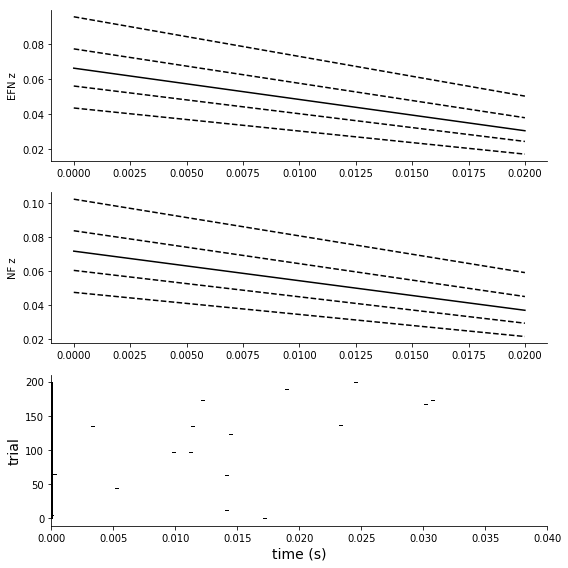

1521 monkey 2, neuron 44, ori 10
MLE estimate
[0.25  0.075]
(1000, 2) (1000, 2)


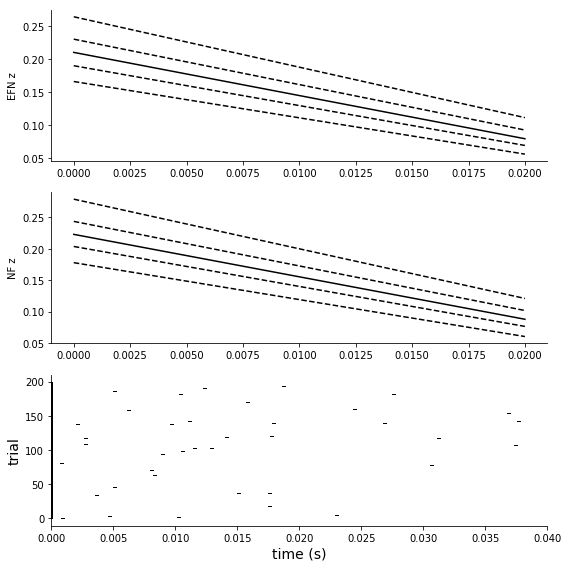

1652 monkey 2, neuron 55, ori 9
MLE estimate
[0.225 0.255]
(1000, 2) (1000, 2)


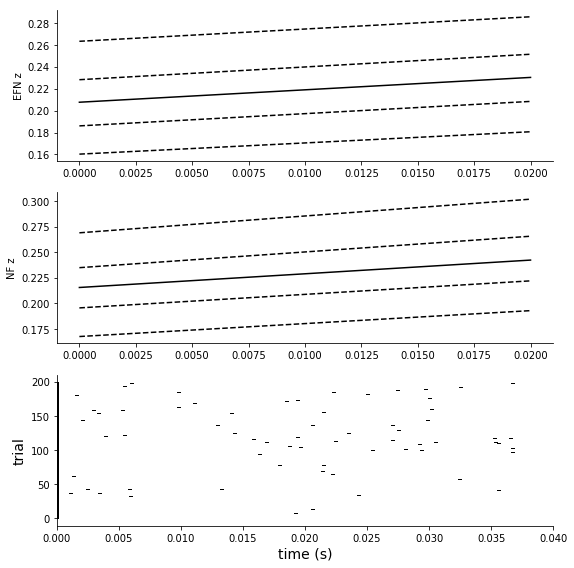

2601 monkey 3, neuron 75, ori 10
MLE estimate
[0.125 0.28 ]
(1000, 2) (1000, 2)


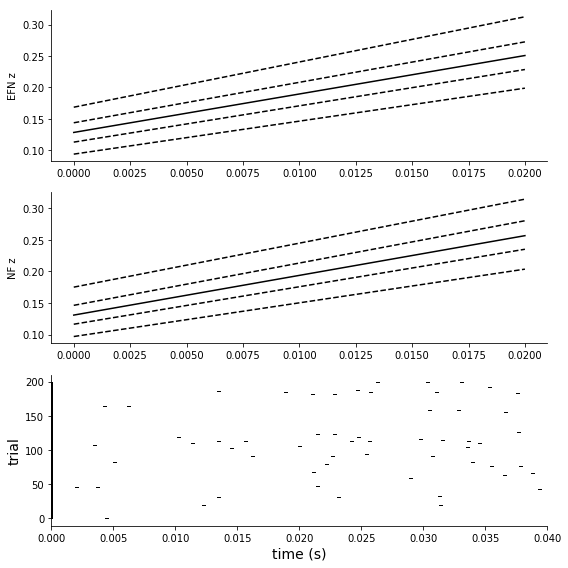

2685 monkey 3, neuron 82, ori 10
MLE estimate
[0.015 0.035]
(1000, 2) (1000, 2)


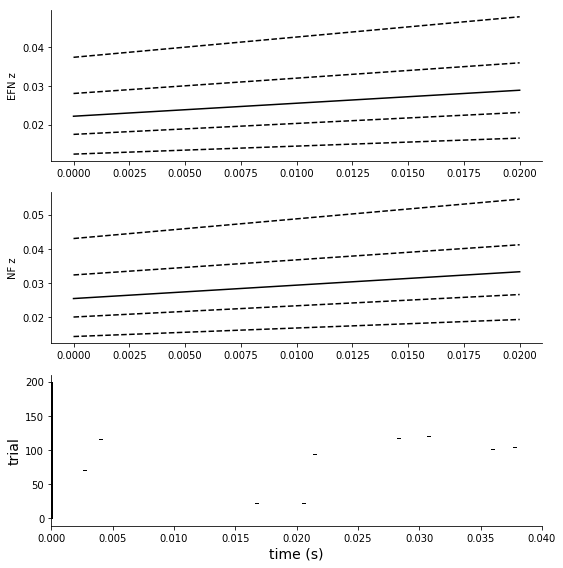

In [41]:
def time_series_contour(Z, prctiles):
    num_prctiles = len(prctiles);
    is_odd = np.mod(num_prctiles,2)==1;
    if (not is_odd):
        print('Error: use odd number of symmetric percentiles');
        return None;
    mid_prctile_ind = num_prctiles // 2;
        
    
    T = Z.shape[1];
    zs = np.zeros((num_prctiles,T));
    for i in range(num_prctiles):
        for t in range(T):
            zs[i,t] = np.percentile(Z[:,t], prctiles[i]);
    

    t = np.linspace(0,(D-1)*T_s, D);
    for i in range(num_prctiles):
        if (i == mid_prctile_ind):
            plt.plot(t,zs[i], 'k');
        else:
            plt.plot(t,zs[i], 'k--');
    return None;
    
prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             stochastic_eta, give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');
efn_test_X = npzfile['test_X'];
efn_test_params = npzfile['test_params'][()];
for i in range(5):
    efn_Z = np.exp(efn_test_X[i,:,:,0]);
    data_ind = efn_test_params[i]['data_ind'];
    monkey = int(monkey_by_ind[data_ind]);
    neuron = int(neuron_by_ind[data_ind]);    
    ori = int(ori_by_ind[data_ind]);
    print(data_ind, 'monkey %d, neuron %d, ori %d' % (monkey, neuron, ori));
    assert(data_ind == family.resp_info_to_ind({'monkey':monkey, 'neuron':neuron, 'ori':ori}));
    
    # load NF model
    dist_info = {'dist_seed':data_ind};
    nf_savedir = basedir + setup_IO(family, 'NF1', dir_str, 'eta', 1, M, flow_dict, param_net_hps, \
                                             stochastic_eta, give_hint, rs, dist_info);
    nf_npzfile = np.load(nf_savedir + 'results.npz');
    nf_X = nf_npzfile['X'][0,:,:,0];
    nf_Z = np.exp(nf_X);
    
    # load counts spikes
    counts, spikes = load_counts_spikes(monkey, neuron, ori);
    print("MLE estimate");
    print(np.mean(counts,0)[:D]);
    spikes = cut_trailing_spikes(spikes, D, T_s);
    
    print(efn_Z.shape, nf_Z.shape);
    fontsize= 14;
    plt.figure(figsize=(8,8));
    plt.subplot(3,1,1);
    time_series_contour(efn_Z, prctiles);
    plt.ylabel('EFN z');
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    
    plt.subplot(3,1,2);
    time_series_contour(nf_Z, prctiles);
    plt.ylabel('NF z');
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    
    

    plt.subplot(3,1,3);
    plt.eventplot(np.array(spikes), colors='k', orientation='horizontal', linewidths=4);
    plt.xlabel('time (s)', fontsize=fontsize);
    plt.ylabel('trial', fontsize=fontsize);
    plt.xlim([0.0,D*T_s]);
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.show();